In [1]:
import time, datetime
import copy
import os
import sys
import warnings
#warnings.filterwarnings("ignore", category=UserWarning)
#warnings.filterwarnings("ignore", category=RuntimeWarning)

import numpy as np
from loguru import logger
import yaml
from utils import dumb_reward_plot
import gym

sys.path.append('./envs/halfcheetah-env')
import halfcheetah_envs

from utils import plot_reward, plot_index
from mpc.mpc_hc import MPC
from baselines.NN import NN
from baselines.NP import NP

def prepare_dynamics(gym_config):
    dynamics_name = gym_config['dynamics_name']
    seed = gym_config['seed']
    dynamics_set = []
    for i in range(len(dynamics_name)):
        env = gym.make(dynamics_name[i])
        # env.seed(seed)
        dynamics_set.append(gym.make(dynamics_name[i]))
    
    # use pre-defined env sequence
    task = [dynamics_set[i] for i in gym_config['task_dynamics_list']]
    return task

def load_config(config_path="config.yml"):
    if os.path.isfile(config_path):
        f = open(config_path)
        return yaml.load(f, Loader=yaml.FullLoader)
    else:
        raise Exception("Configuration file is not found in the path: "+config_path)


In [2]:
config = load_config('./config/config_halfcheetah.yml')
nn_config = config['NN_config']
mpc_config = config['mpc_config']
gym_config = config['gym_config']
render = gym_config['render']
np_config = config['NP_config']

# initialize the mixture model
# model = DPGPMM(dpgp_config=dpgp_config)
# model = SingleSparseGP(sparse_gp_config=sparse_gp_config)
# model = SingleGP(gp_config=gp_config)
# model_test =
# NOTICE: Model
#  ###########
# model = NN(NN_config=nn_config)
model = NP(NP_config=np_config)
logger.info('Using model: {}', model.name)

# initial MPC controller
mpc_controller = MPC(mpc_config=mpc_config)

# prepare task
# the task is solved, if each dynamic is solved
task = prepare_dynamics(gym_config)
print(gym_config)

"""start DPGP-MBRL"""
data_buffer = []
label_list = []
subtask_list = []
subtask_reward = []
subtask_succ_count = [0]
comp_trainable = [1]
task_reward = []
trainable = True
task_solved = False
subtask_solved = [False, False, False, False]
total_count = 0
task_epi = 0
log_name = None

total_tasks = 1  #4

2020-05-22 12:30:50.705 | INFO     | __main__:<module>:17 - Using model: NP


set init mean to 0
{'render': False, 'task_dynamics_list': [0, 1], 'subtask_episode': 5, 'task_episode': 100, 'seed': 1000, 'dynamics_name': ['HalfCheetahSlope00m04-v1', 'HalfCheetahSlope00m34-v1']}


KeyboardInterrupt: 

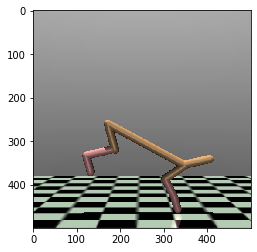

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
"""NN pretrain"""
pretrain_episodes = 2
for task_idx in range(total_tasks):
    env = task[task_idx]
    # data collection
    for epi in range(pretrain_episodes):
        obs = env.reset()
        done = False
        mpc_controller.reset()
        while not done:
            action = env.action_space.sample()
            obs_next, reward, done, state_next = env.step(action)
            plt.imshow(env.render(mode='rgb_array')) 
            display.display(plt.gcf())  
            display.clear_output(wait=True)
            model.data_process([0, obs, action, obs_next - obs])
            obs = copy.deepcopy(obs_next)

#print('collected data: ', len(data))
# training the model
# NOTICE: Model
#  ###########
model.validation_flag = True
#model.n_epochs = 20
# print('model.data =', model.data)
# print('model.data.size() =', model.data.size())
# print('model.label =', model.label)
# print('model.label.size() =', model.label.size())
model.fit()

In [5]:
"""testing the model with MPC while training """
test_episode = 2
test_epoch = 20
log = []
for ep in range(test_epoch):
    print('epoch: ', ep)
    for task_idx in range(total_tasks):
        env = task[task_idx]
        print('task: ', task_idx)
        for epi in range(test_episode):
            #print('episode: ', epi)
            acc_reward = 0
            obs = env.reset()

            O, A, R, acc_reward, done = [], [], [], 0, False
            mpc_controller.reset()
            i = 0
            while not done:
                i+= 1

                # env.render()
                env_copy = prepare_dynamics(gym_config)[task_idx]
                env_copy.reset()
                # NOTICE: Model
                #  ###########
                action = np.array([mpc_controller.act(task=env_copy, model=model, state=obs)])
                obs_next, reward, done, state_next = env.step(action)
                A.append(action)
                O.append(state_next)
                R.append(reward)

                # append data but not training
                # NOTICE: Model
                #  ###########
                model.data_process([0, obs, action[0], obs_next - obs])
                obs = copy.deepcopy(obs_next)
                acc_reward += reward
                # logger.info('reward: {}', reward)
                #time.sleep(0.1)
            print('task: ', task_idx,'step: ', i, 'acc_reward: ', acc_reward)
            env.close()

            if done:
                samples = {
                    "obs": np.array(O),
                    "actions": np.array(A),
                    "rewards": np.array(R),
                    "reward_sum": acc_reward,
                }
                print('******************')
                print('acc_reward', acc_reward)
                print('******************')
                log.append(samples)
                if log_name is None:
                    log_name = datetime.datetime.now()
                path = './misc/log/' + log_name.strftime("%d-%H-%M") + '.npy'
                np.save(path, log, allow_pickle=True)
                dumb_reward_plot(path)

        # use the collected date to train model
        print('fitting the model...')
        #model.n_epochs = 20

        # NOTICE: Model
        #  ###########
        model.fit()

epoch:  0
task:  0
set init mean to 0
task:  0 step:  200 acc_reward:  89.81746767130268
******************
acc_reward 89.81746767130268
******************
set init mean to 0
task:  0 step:  200 acc_reward:  -11.910349646823459
******************
acc_reward -11.910349646823459
******************
fitting the model...
fitting model
X.size() = torch.Size([12400, 24])
RESHAPED X.size() = torch.Size([1, 12400, 24])
epoch:  1
task:  0
set init mean to 0
task:  0 step:  200 acc_reward:  42.648814798963265
******************
acc_reward 42.648814798963265
******************
set init mean to 0
task:  0 step:  200 acc_reward:  56.5197532246303
******************
acc_reward 56.5197532246303
******************
fitting the model...
fitting model
X.size() = torch.Size([12800, 24])
RESHAPED X.size() = torch.Size([1, 12800, 24])
epoch:  2
task:  0
set init mean to 0
task:  0 step:  200 acc_reward:  71.33255368752089
******************
acc_reward 71.33255368752089
******************
set init mean to 0
t